In [1]:
from __future__ import absolute_import, division, print_function

import numpy as np
import time
import itertools
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data
import torch.optim as optim

import seaborn as sns


from torch.utils.data import Dataset
from torch.utils.data import DataLoader

np.set_printoptions(precision=3)

### 1. Generate channel samples

In [2]:
## Generate location of D2D users and CUE
def loc_init(Size_area, Dist_TX_RX, Num_D2D, Num_Ch):
    tx_loc = Size_area * (np.random.rand(Num_D2D, 2) - 0.5)
    rx_loc = np.zeros((Num_D2D + 1, 2))
    for i in range(Num_D2D):
        temp_chan = Feasible_Loc_Init(tx_loc[i, :], Size_area, Dist_TX_RX)
        rx_loc[i, :] = temp_chan
    tx_loc_CUE = Size_area * (np.random.rand(Num_Ch, 2) - 0.5)

    return rx_loc, tx_loc, tx_loc_CUE

In [3]:
## Check the feasibililty of generated location
def Feasible_Loc_Init(Cur_loc, Size_area, Dist_TX_RX):
    temp_dist = 2 * Dist_TX_RX * (np.random.rand(1, 2) - 0.5)
    temp_chan = Cur_loc + temp_dist
    while (np.max(abs(temp_chan)) > Size_area / 2) | (np.linalg.norm(temp_dist) > Dist_TX_RX):
        temp_dist = 2 * Dist_TX_RX * (np.random.rand(1, 2) - 0.5)
        temp_chan = Cur_loc + temp_dist
    return temp_chan


In [4]:
## Generate sample data for channel
def ch_gen(Size_area, D2D_dist, Num_D2D, Num_Ch, Num_samples, PL_alpha=38., PL_const=34.5):
    ch_w_fading = []
    rx_loc_mat = []
    tx_loc_mat = []
    CUE_loc_mat = []
    
    ch_w_fading = []

    ## Perform initialization just once and the rest channel is generated by moving users
    rx_loc, tx_loc, tx_loc_CUE = loc_init(Size_area, D2D_dist, Num_D2D, Num_Ch)

    ## Calculate the
    for i in range(Num_samples):

        rx_loc, tx_loc, tx_loc_CUE = loc_init(Size_area, D2D_dist, Num_D2D, Num_Ch)

        ch_w_temp_band = []
        for j in range(Num_Ch):
            tx_loc_with_CUE = np.vstack((tx_loc, tx_loc_CUE[j]))
            ## generate distance_vector
            dist_vec = rx_loc.reshape(Num_D2D + 1, 1, 2) - tx_loc_with_CUE
            dist_vec = np.linalg.norm(dist_vec, axis=2)
            dist_vec = np.maximum(dist_vec, 3)

            # find path loss // shadowing is not considered
            pu_ch_gain_db = - PL_const - PL_alpha * np.log10(dist_vec)
            pu_ch_gain = 10 ** (pu_ch_gain_db / 10)

            multi_fading = 0.5 * np.random.randn(Num_D2D + 1, Num_D2D + 1) ** 2 + 0.5 * np.random.randn(Num_D2D + 1,
                                                                                                        Num_D2D + 1) ** 2
            final_ch = np.maximum(pu_ch_gain * multi_fading, np.exp(-30))
            ch_w_temp_band.append(np.transpose(final_ch))

        ch_w_fading.append(ch_w_temp_band)
        rx_loc_mat.append(rx_loc)
        tx_loc_mat.append(tx_loc)
        CUE_loc_mat.append(tx_loc_CUE)
        
    return np.array(ch_w_fading), np.array(rx_loc_mat), np.array(tx_loc_mat), np.array(CUE_loc_mat)


#### Simulation setting

In [5]:
## Simulation setting for sample channel data

Size_area = 50.0
D2D_dist = 10
Num_user = 2
Num_channel = 2
num_samples_tr = 30

#### A. Randomly generated training data - 30 sample

In [6]:
ch_mat, rx_mat, tx_mat, CUE_mat = ch_gen(Size_area, D2D_dist, Num_user, Num_channel, num_samples_tr)

#### B. Check the location of users

In [7]:
rx_mat[0]

array([[  7.72552648,   8.55407105],
       [-17.35339839,   2.52105604],
       [  0.        ,   0.        ]])

In [8]:
tx_mat[0]

array([[ 6.22358933,  8.90841874],
       [-8.88039958,  5.60632327]])

In [9]:
CUE_mat[0]

array([[ -0.46556057, -21.18098215],
       [ 22.30768418,  11.91720812]])

In [10]:
rx_mat.shape

(30, 3, 2)

#### C. Check the location and transmit pairs

In [11]:
## Change the shape of location matrice to facilitate the plot
## Squeeze all the location of different sample
rx_mat_temp = rx_mat[:,:-1,:].reshape(num_samples_tr*Num_user, -1)
tx_mat_temp = tx_mat.reshape(num_samples_tr*Num_user, -1)
CUE_mat_temp = CUE_mat.reshape(num_samples_tr*Num_channel, -1)

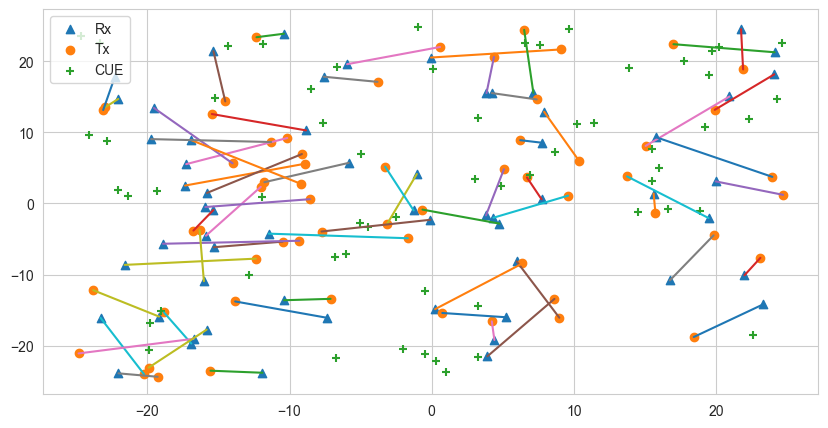

In [12]:
plt.figure(figsize=(10,5))

plt.scatter(rx_mat_temp[:, 0], rx_mat_temp[:, 1], marker='^', label='Rx')
plt.scatter(tx_mat_temp[:, 0], tx_mat_temp[:, 1], marker='o', label='Tx')
plt.scatter(CUE_mat_temp[:, 0], CUE_mat_temp[:, 1], marker='+', label='CUE')
plt.legend(loc='upper left')

for i in range(rx_mat_temp.shape[0]):
    plt.plot([rx_mat_temp[i, 0], tx_mat_temp[i, 0]], [rx_mat_temp[i,1], tx_mat_temp[i, 1]])

#### D. plotting by varying the distance between communicating users

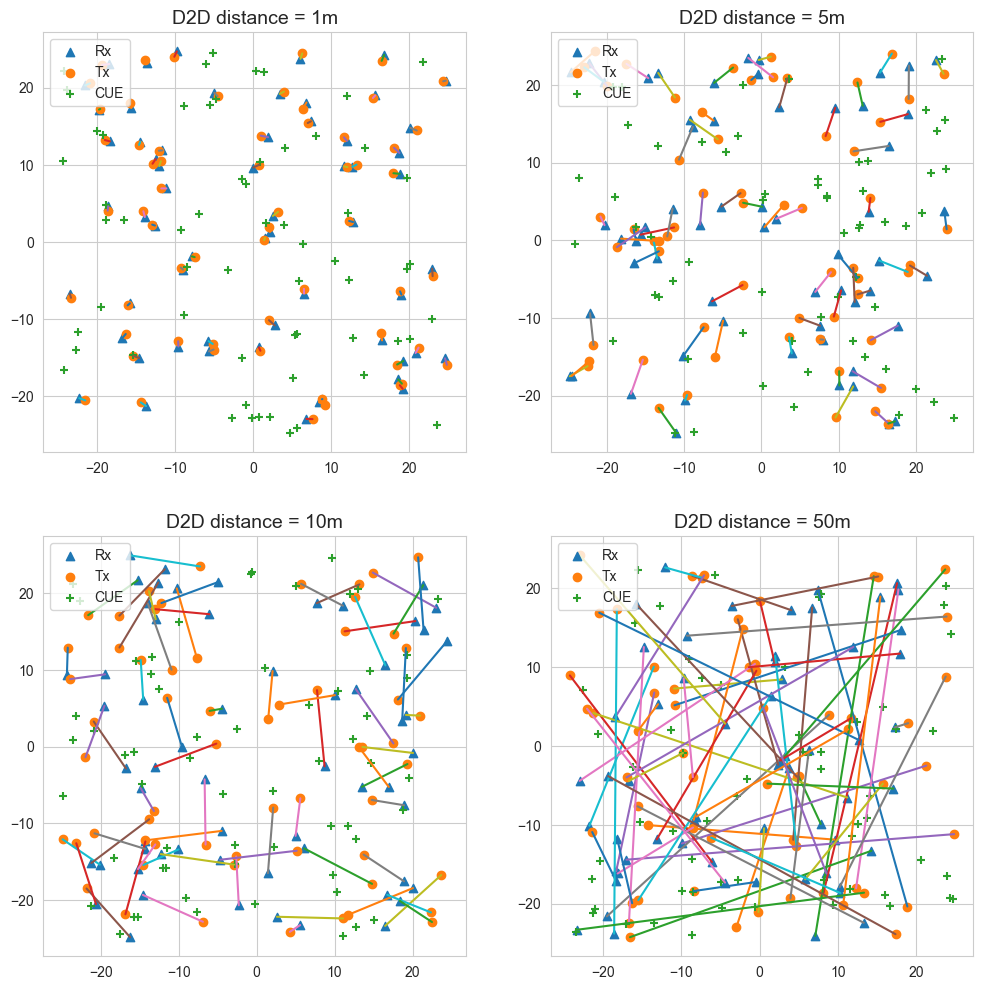

In [13]:
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
D2D_dist_mat = [1, 5, 10, 50]
for i in range(4):
    D2D_dist = D2D_dist_mat[i]
    ch_mat, rx_mat, tx_mat, CUE_mat = ch_gen(Size_area, D2D_dist, Num_user, Num_channel, num_samples_tr)
    rx_mat_temp = rx_mat[:,:-1,:].reshape(num_samples_tr*Num_user, -1)
    tx_mat_temp = tx_mat.reshape(num_samples_tr*Num_user, -1)
    CUE_mat_temp = CUE_mat.reshape(num_samples_tr*Num_channel, -1)

    axes[i//2, i%2].scatter(rx_mat_temp[:, 0], rx_mat_temp[:, 1], marker='^', label='Rx')
    axes[i//2, i%2].scatter(tx_mat_temp[:, 0], tx_mat_temp[:, 1], marker='o', label='Tx')
    axes[i//2, i%2].scatter(CUE_mat_temp[:, 0], CUE_mat_temp[:, 1], marker='+', label='CUE')
    axes[i//2, i%2].legend(loc='upper left')
    axes[i//2, i%2].set_title(f"D2D distance = {D2D_dist}m", fontsize=14)

    for j in range(rx_mat_temp.shape[0]):
        axes[i//2, i%2].plot([rx_mat_temp[j, 0], tx_mat_temp[j, 0]], [rx_mat_temp[j,1], tx_mat_temp[j, 1]])

#### E. Check the channel statistics of channel gain

In [14]:
D2D_dist = 1

In [15]:
ch_mat, _, _ , _ = ch_gen(Size_area, D2D_dist, Num_user, Num_channel, int(10**4))

In [16]:
ch_mat.shape

(10000, 2, 3, 3)

In [17]:
sig_chan = np.ravel(ch_mat[:,:,:-1,:-1].diagonal(0, 2, 3))

#### Plotting in decimal

(array([1.45443596e+05, 8.86798117e+04, 5.50416629e+04, 3.49817823e+04,
        1.97854766e+04, 1.28307538e+04, 8.45921380e+03, 5.08120560e+03,
        3.21715066e+03, 2.00598806e+03, 1.20170039e+03, 7.56976626e+02,
        3.97412729e+02, 1.98706364e+02, 1.89244156e+02, 1.13546494e+02,
        3.78488313e+01, 4.73110391e+01, 9.46220782e+00, 9.46220782e+00]),
 array([7.18653986e-12, 2.64209669e-06, 5.28418620e-06, 7.92627571e-06,
        1.05683652e-05, 1.32104547e-05, 1.58525442e-05, 1.84946337e-05,
        2.11367232e-05, 2.37788127e-05, 2.64209023e-05, 2.90629918e-05,
        3.17050813e-05, 3.43471708e-05, 3.69892603e-05, 3.96313498e-05,
        4.22734393e-05, 4.49155288e-05, 4.75576183e-05, 5.01997078e-05,
        5.28417973e-05]),
 <BarContainer object of 20 artists>)

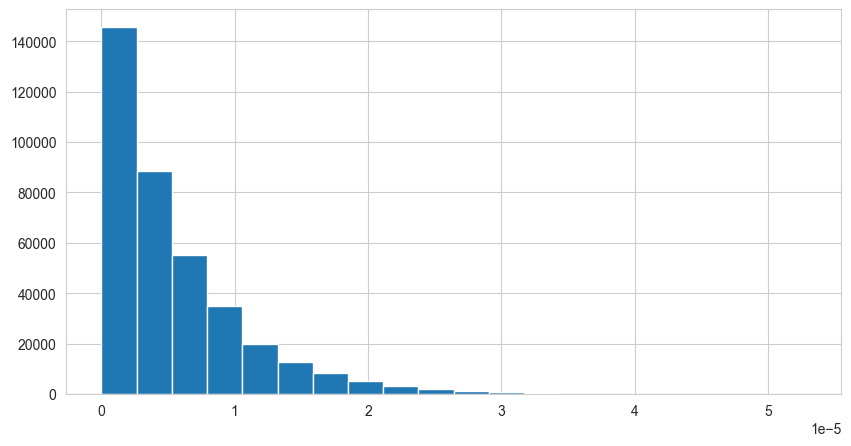

In [18]:
plt.figure(figsize=(10,5))
plt.hist(sig_chan, bins=20, density=True)

<Axes: ylabel='Percent'>

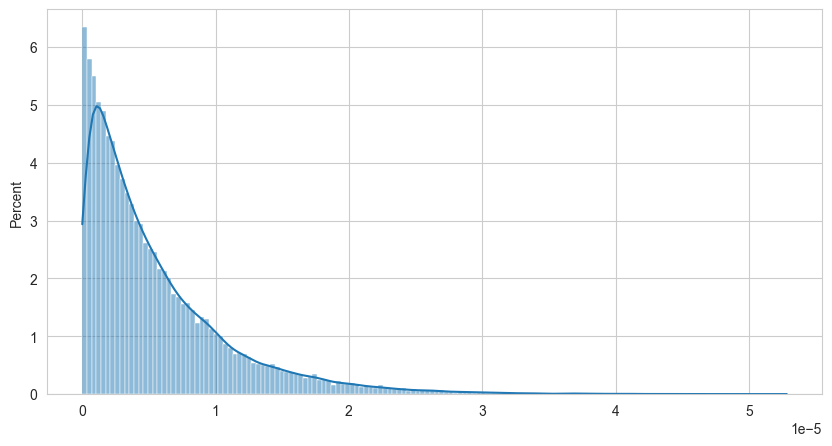

In [19]:
plt.figure(figsize=(10,5))
sns.histplot(data=sig_chan, kde=True, stat="percent")

#### Normalizing through dB operation

(array([7.28177495e-06, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        7.28177495e-06, 2.18453249e-05, 8.73812994e-05, 1.52917274e-04,
        3.34961648e-04, 4.44188272e-04, 1.31800127e-03, 2.73066561e-03,
        5.78172931e-03, 1.28814599e-02, 2.56464114e-02, 4.80961236e-02,
        7.53663708e-02, 7.87888050e-02, 3.59209958e-02, 3.68457813e-03]),
 array([-111.43480162, -108.00157274, -104.56834387, -101.135115  ,
         -97.70188613,  -94.26865726,  -90.83542839,  -87.40219952,
         -83.96897065,  -80.53574177,  -77.1025129 ,  -73.66928403,
         -70.23605516,  -66.80282629,  -63.36959742,  -59.93636855,
         -56.50313968,  -53.0699108 ,  -49.63668193,  -46.20345306,
         -42.77022419]),
 <BarContainer object of 20 artists>)

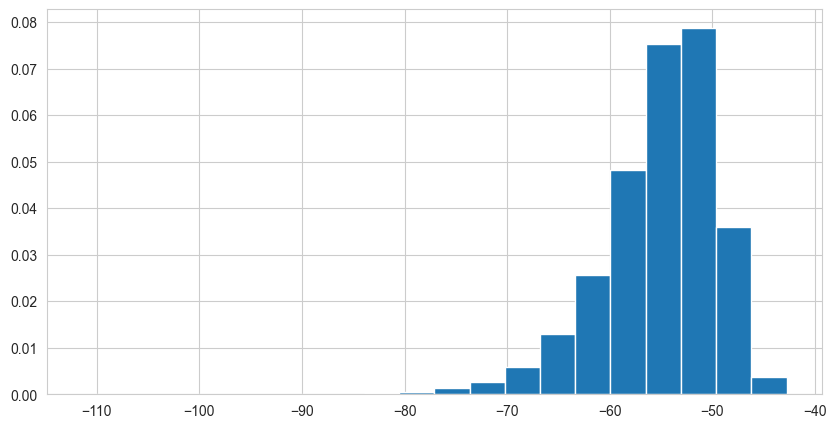

In [20]:
plt.figure(figsize=(10,5))
plt.hist(10*np.log10(sig_chan), bins=20, density=True)

<Axes: ylabel='Percent'>

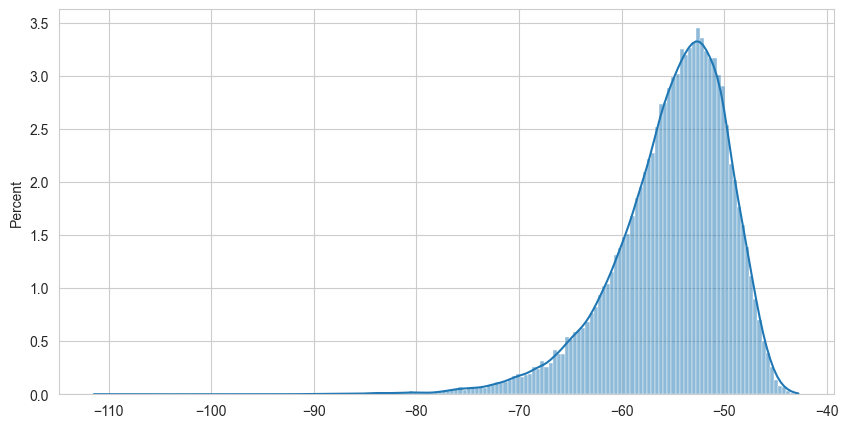

In [21]:
plt.figure(figsize=(10,5))
sns.histplot(data=10*np.log10(sig_chan), kde=True, stat="percent")

#### F. Check the channel statistics of interference

In [22]:
int_temp = np.triu(ch_mat, 1)

In [23]:
int_temp.shape

(10000, 2, 3, 3)

In [24]:
int_chan = int_temp[:,:,:,:-1][int_temp[:,:,:,:-1]!=0]

(array([8.48424062e+05, 6.40842917e+03, 3.50731596e+03, 1.86190847e+03,
        1.42890650e+03, 9.52604336e+02, 7.36103351e+02, 3.89701774e+02,
        2.59801183e+02, 3.03101380e+02, 3.46401577e+02, 8.66003942e+01,
        2.59801183e+02, 3.03101380e+02, 2.16500985e+02, 2.59801183e+02,
        8.66003942e+01, 8.66003942e+01, 0.00000000e+00, 8.66003942e+01]),
 array([9.35762297e-14, 1.15472925e-06, 2.30945840e-06, 3.46418756e-06,
        4.61891671e-06, 5.77364587e-06, 6.92837502e-06, 8.08310418e-06,
        9.23783333e-06, 1.03925625e-05, 1.15472916e-05, 1.27020208e-05,
        1.38567500e-05, 1.50114791e-05, 1.61662083e-05, 1.73209374e-05,
        1.84756666e-05, 1.96303957e-05, 2.07851249e-05, 2.19398540e-05,
        2.30945832e-05]),
 <BarContainer object of 20 artists>)

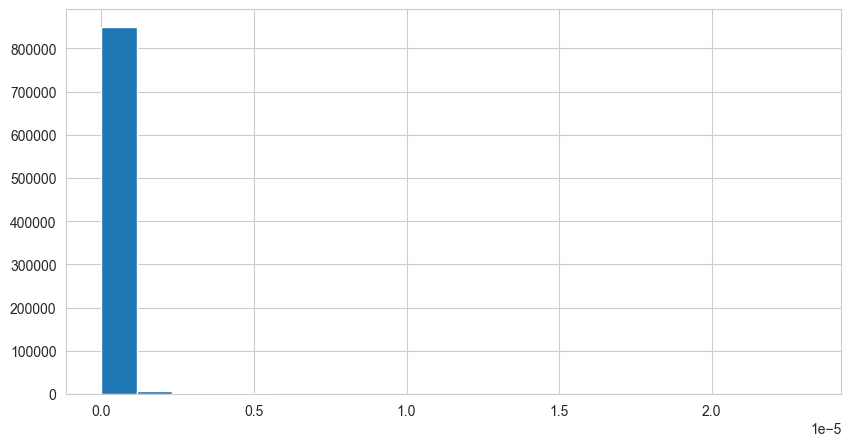

In [25]:
plt.figure(figsize=(10,5))
plt.hist(int_chan, bins=20, density=True)

(array([7.14937279e-05, 1.90649941e-04, 3.33637397e-04, 1.22730900e-03,
        2.77633977e-03, 6.87531350e-03, 1.52639109e-02, 2.79063851e-02,
        4.00245720e-02, 4.03105469e-02, 3.15763965e-02, 2.39503988e-02,
        1.72419040e-02, 1.13317559e-02, 7.30427586e-03, 4.34920178e-03,
        3.10997716e-03, 2.27588367e-03, 1.52519953e-03, 6.67274793e-04]),
 array([-130.28834457, -126.09217228, -121.89599999, -117.69982769,
        -113.5036554 , -109.30748311, -105.11131081, -100.91513852,
         -96.71896623,  -92.52279394,  -88.32662164,  -84.13044935,
         -79.93427706,  -75.73810476,  -71.54193247,  -67.34576018,
         -63.14958789,  -58.95341559,  -54.7572433 ,  -50.56107101,
         -46.36489871]),
 <BarContainer object of 20 artists>)

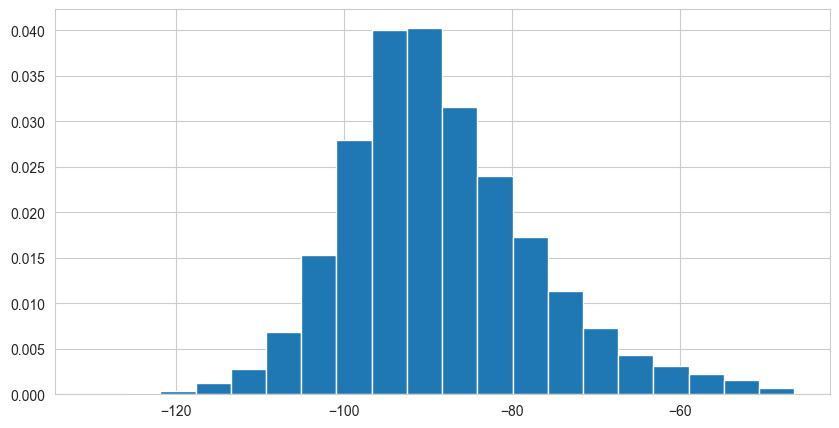

In [26]:
plt.figure(figsize=(10,5))
plt.hist(10*np.log10(int_chan), bins=20, density=True)

<Axes: ylabel='Percent'>

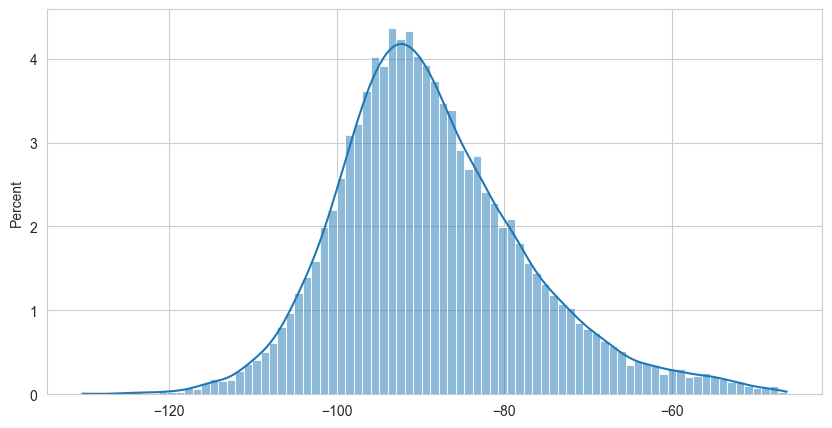

In [27]:
plt.figure(figsize=(10,5))
sns.histplot(data=10*np.log10(int_chan), kde=True, stat="percent")

In [28]:
cue_chan = int_temp[:,:,:,-1][int_temp[:,:,:,-1]!=0]

In [29]:
int_chan.shape

(20000,)

In [30]:
cue_chan.shape

(40000,)

(array([3.50729947e-05, 4.09184938e-05, 7.59914885e-05, 1.98746970e-04,
        7.18996391e-04, 1.98746970e-03, 4.92191025e-03, 1.14337963e-02,
        2.52525562e-02, 4.44024113e-02, 4.99030259e-02, 3.84575387e-02,
        2.30195755e-02, 1.34914120e-02, 8.17785326e-03, 4.67055379e-03,
        3.16826052e-03, 2.10437968e-03, 1.39707429e-03, 3.62420945e-04]),
 array([-130.28834457, -126.01154981, -121.73475504, -117.45796028,
        -113.18116552, -108.90437076, -104.62757599, -100.35078123,
         -96.07398647,  -91.7971917 ,  -87.52039694,  -83.24360218,
         -78.96680741,  -74.69001265,  -70.41321789,  -66.13642312,
         -61.85962836,  -57.5828336 ,  -53.30603883,  -49.02924407,
         -44.75244931]),
 <BarContainer object of 20 artists>)

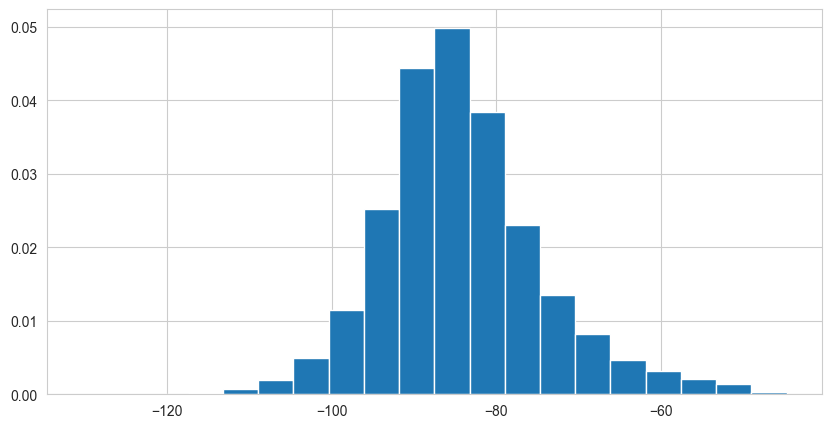

In [31]:
plt.figure(figsize=(10,5))
plt.hist(10*np.log10(cue_chan), bins=20, density=True)

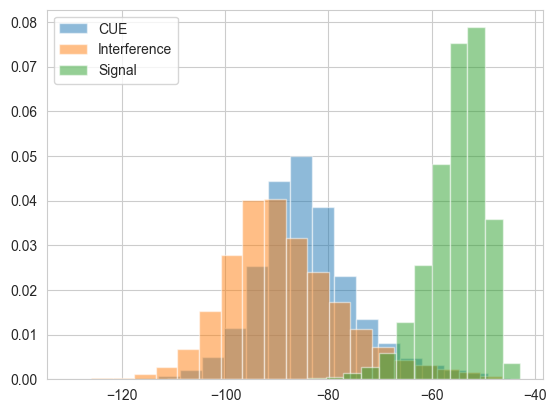

In [32]:
plt.hist(10*np.log10(cue_chan), bins=20, alpha=0.5, label='CUE', density=True)
plt.hist(10*np.log10(int_chan), bins=20, alpha=0.5, label='Interference', density=True)
plt.hist(10*np.log10(sig_chan), bins=20, alpha=0.5, label='Signal', density=True)

plt.legend(loc='upper left')


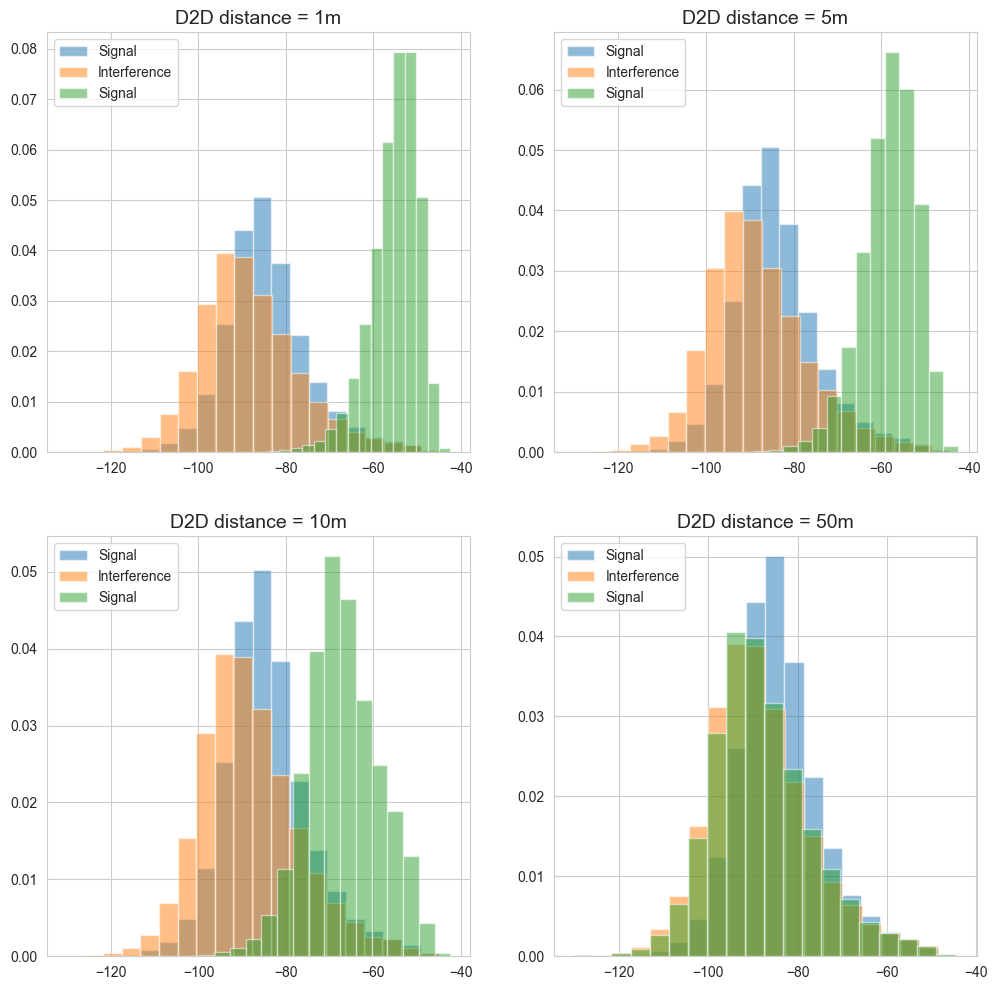

In [33]:
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
D2D_dist_mat = [1, 5, 10, 50]
for i in range(4):
    D2D_dist = D2D_dist_mat[i]
    ch_mat, _, _ , _ = ch_gen(Size_area, D2D_dist, Num_user, Num_channel, int(10**4))
    sig_chan = np.ravel(ch_mat[:,:,:-1,:-1].diagonal(0, 2, 3))
    int_temp = np.triu(ch_mat, 1)
    int_chan = int_temp[:,:,:,:-1][int_temp[:,:,:,:-1]!=0]
    cue_chan = int_temp[:,:,:,-1][int_temp[:,:,:,-1]!=0]

    axes[i//2, i%2].hist(10*np.log10(cue_chan), bins=20, alpha=0.5, label='Signal', density=True) 
    axes[i//2, i%2].hist(10*np.log10(int_chan), bins=20, alpha=0.5, label='Interference', density=True)
    axes[i//2, i%2].hist(10*np.log10(sig_chan), bins=20, alpha=0.5, label='Signal', density=True) 
    axes[i//2, i%2].legend(loc='upper left')
    axes[i//2, i%2].set_title(f"D2D distance = {D2D_dist}m", fontsize=14)

### Calculate the data rate using the given channel and resource allocation

In [34]:
## Calculate data rate for single channel, single sample
def cal_RATE_one_sample_one_channel(channel, tx_power, noise):
    diag_ch = np.diag(channel)
    inter_ch = channel-np.diag(diag_ch)
    tot_ch = np.multiply(channel, np.expand_dims(tx_power, -1))
    int_ch = np.multiply(inter_ch, np.expand_dims(tx_power, -1))
    sig_ch = np.sum(tot_ch-int_ch, axis=1)
    int_ch = np.sum(int_ch, axis=1)
    SINR_val = np.divide(sig_ch, int_ch+noise)
    cap_val = np.log2(1.0+SINR_val)
    return cap_val


In [35]:
def cal_CUE_INTER_one_sample_one_channel(channel, tx_power):
    diag_ch = np.diag(channel)
    inter_ch = channel-np.diag(diag_ch)
    int_ch = np.multiply(inter_ch, np.expand_dims(tx_power, -1))
    int_ch = np.sum(int_ch, axis=1)
    return int_ch


In [36]:
D2D_dist = 10

#### Randomly generate channel matrix

In [37]:
ch_mat, rx_mat, tx_mat, CUE_mat = ch_gen(Size_area, D2D_dist, Num_user, Num_channel, int(10**4))

#### Set all-one transmit power vector

In [38]:
tx_power_temp = np.ones((1, 3))
BW = 1e7
noise = BW*10**-17.4
tx_power_temp

array([[1., 1., 1.]])

#### Calculate the data rate for all users

In [39]:
cal_RATE_one_sample_one_channel(ch_mat[0, 0, :,:], tx_power_temp, noise)

array([[9.96225689, 7.26195681, 0.45806998]])

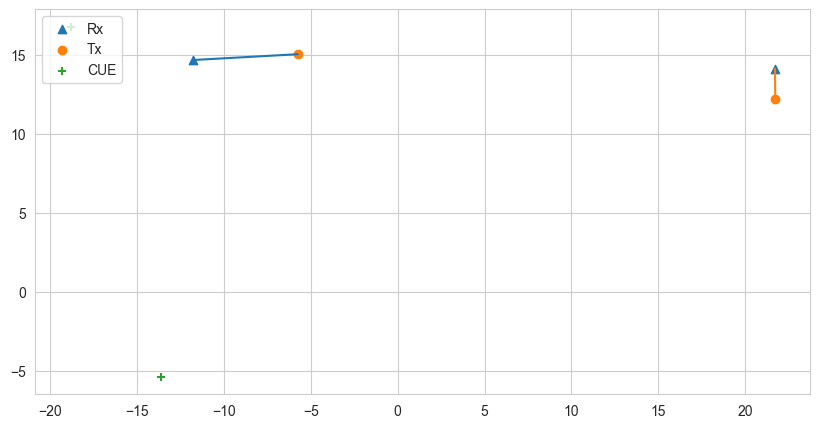

In [40]:
rx_mat_temp = rx_mat[:,:-1,:].reshape(Num_user, -1)
tx_mat_temp = tx_mat.reshape(Num_user, -1)
CUE_mat_temp = CUE_mat.reshape(Num_channel, -1)

plt.figure(figsize=(10,5))

plt.scatter(rx_mat_temp[:, 0], rx_mat_temp[:, 1], marker='^', label='Rx')
plt.scatter(tx_mat_temp[:, 0], tx_mat_temp[:, 1], marker='o', label='Tx')
plt.scatter(CUE_mat_temp[:, 0], CUE_mat_temp[:, 1], marker='+', label='CUE')
plt.legend(loc='upper left')

for i in range(rx_mat_temp.shape[0]):
    plt.plot([rx_mat_temp[i, 0], tx_mat_temp[i, 0]], [rx_mat_temp[i,1], tx_mat_temp[i, 1]])

#### Calculate Rate, EE, outage for multiple samples

In [41]:
def cal_rate_NP(channel, tx_power_in, tx_max, noise, DUE_thr, I_thr, P_c):
    num_sample = channel.shape[0]
    num_channel = channel.shape[1]
    num_D2D_user = channel.shape[2] - 1

    ## Initialization
    tot_SE = 0
    tot_EE = 0
    tot_cap_CUE_vio = 0
    tot_cap_DUE_vio = 0
    tot_cap_CUE_vio_num = 0.001
    tot_cap_DUE_vio_num = 0.001
    DUE_violation = 0
    CUE_violation = 0
    tot_success_prob = 0
    
    ## Append tx power and CUE tx power
    tx_power = np.hstack((tx_power_in, tx_max * np.ones((tx_power_in.shape[0], 1, num_channel))))

    for i in range(num_sample):
        cur_cap = 0
        DUE_mask = 1
        CUE_mask = 1

        for j in range(num_channel):
            cur_ch = channel[i][j]
            cur_power = tx_power[i, :, j]
            cur_power = np.array([cur_power])
            cur_ch_cap = cal_RATE_one_sample_one_channel(cur_ch, cur_power, noise)
            inter = cal_CUE_INTER_one_sample_one_channel(cur_ch, cur_power)
            cur_cap = cur_cap + cur_ch_cap[0]
            CUE_mask = CUE_mask * (inter[0, num_D2D_user] <= I_thr)

        for j in range(num_D2D_user):
            DUE_mask = DUE_mask * (cur_cap[j] >= DUE_thr)

        D2D_SE_sum = np.sum(cur_cap[:-1])*CUE_mask*DUE_mask
        D2D_EE_sum = np.sum(cur_cap[:-1]/(np.sum(tx_power_in[i], axis=1)+P_c))*CUE_mask*DUE_mask

        if CUE_mask == 0:
            CUE_violation = CUE_violation + 1
            
        if DUE_mask == 0:
            DUE_violation = DUE_violation + 1

        tot_SE = tot_SE + D2D_SE_sum
        tot_EE = tot_EE + D2D_EE_sum


    tot_SE = tot_SE / num_D2D_user / num_sample
    tot_EE = tot_EE / num_D2D_user / num_sample
    PRO_DUE_vio = DUE_violation / (num_sample)
    PRO_CUE_vio = CUE_violation / (num_sample)

    return tot_SE, tot_EE, PRO_CUE_vio, PRO_DUE_vio



#### Check the validity of the function
**** tx_power_in은 D2D tx power만 고려함
**** All ones transmit power

In [42]:
tx_power_in = 10**2.0*np.ones((ch_mat.shape[0], 2, 2))

In [43]:
DUE_thr = 0.0
tx_max = 10**2.0
I_thr = 10**(-10.0/10)
P_c = 10**2.0
BW = 1e7
noise = BW*10**-17.4

In [44]:
cal_rate_NP(ch_mat, tx_power_in, tx_max, noise, DUE_thr, I_thr, P_c)

(np.float64(10.568097915140118), np.float64(0.0352269930504673), 0.0, 0.0)

In [45]:
DUE_thr = 4.0
tx_max = 10**2.0
I_thr = 10**(-55.0/10)
P_c = 10**2.0
BW = 1e7
noise = BW*10**-17.4

In [46]:
cal_rate_NP(ch_mat, tx_power_in, tx_max, noise, DUE_thr, I_thr, P_c)

(np.float64(6.053241209146343),
 np.float64(0.020177470697154472),
 0.3801,
 0.2677)

#### Essential function for optimal scheme

In [47]:
def all_possible_tx_power(num_channel, num_user, granuty):

    items = [np.arange(granuty)] * num_user * num_channel
    temp_power = list(itertools.product(*items))
    temp_power = np.reshape(temp_power, (-1, num_user, num_channel))

    power_check = np.sum(temp_power, axis=2)
    flag = (power_check / (granuty - 1) <= 1).astype(int)
    flag = (np.sum(flag, axis=1) / num_user == 1).astype(int)
    flag = np.reshape(flag, (-1, 1))
    temp_power_1 = np.reshape(temp_power, (-1, num_user * num_channel))
    temp_power = temp_power_1 * flag
    power = np.reshape(temp_power, (-1, num_user, num_channel)) / (granuty - 1)

    power_mat = []
    for i in range(power.shape[0]):
        sum_val = np.sum(power[i])
        if sum_val != 0:
            power_mat.append(power[i])

    return np.array(power_mat)


In [48]:
def optimal_power(channel, tx_max, noise, DUE_thr, I_thr, P_c, tx_power_set, opt="SE"):

    num_channel = channel.shape[1]
    num_D2D_user = channel.shape[2] - 1
    num_samples = channel.shape[0]
    tot_SE = 0
    power_mat_SE = []
    chan_infea_mat = []

    for i in tqdm(range(num_samples)):
        cur_cap = 0
        DUE_mask = 1
        CUE_mask = 1
        tx_power = tx_max * np.hstack((tx_power_set, np.ones((tx_power_set.shape[0], 1, num_channel))))

        for j in range(num_channel):
            cur_ch = channel[i][j]
            cur_ch_cap = cal_RATE_one_sample_one_channel(cur_ch, tx_power[:, :, j], noise)
            inter = cal_CUE_INTER_one_sample_one_channel(cur_ch, tx_power[:, :, j])
            cur_cap = cur_cap + cur_ch_cap
            CUE_mask = CUE_mask * (inter[:, num_D2D_user] < I_thr)
        
        for j in range(num_D2D_user):
            DUE_mask = DUE_mask * (cur_cap[:,j] > DUE_thr)
        
        CUE_mask = np.expand_dims(CUE_mask, -1)
        DUE_mask = np.expand_dims(DUE_mask, -1)
        
        sum_D2D_SE_temp = np.expand_dims(np.sum(cur_cap[:,:-1], axis=1), -1)
        sum_D2D_EE_temp = np.expand_dims(np.sum(cur_cap[:,:-1]/(np.sum(tx_power[:,:-1,:], axis=2)+P_c), axis=1), -1)
        
        D2D_SE_sum = sum_D2D_SE_temp*CUE_mask*DUE_mask
        D2D_EE_sum = sum_D2D_EE_temp*CUE_mask*DUE_mask

        if opt=="SE":
            arg_max_val = np.argmax(D2D_SE_sum)
        else:
            arg_max_val = np.argmax(D2D_EE_sum)
            
        max_SE = np.max(D2D_SE_sum)
        
        found_tx_val = tx_power[arg_max_val][:-1]

        power_mat_SE.append(found_tx_val)
        
        ## Collect the infeasible channels
        if max_SE == 0:
            chan_infea_mat.append(channel[i])
            

    power_mat_SE = np.array(power_mat_SE)

    tot_SE, tot_EE, PRO_CUE_vio, PRO_DUE_vio = cal_rate_NP(channel, power_mat_SE, tx_max, noise, DUE_thr, I_thr, P_c)

    return tot_SE, tot_EE, PRO_CUE_vio, PRO_DUE_vio, np.array(chan_infea_mat)



#### Set the granuity level of transmit power as 20

In [49]:
Num_power_level = 10

In [50]:
tx_power_set = all_possible_tx_power(Num_channel, Num_user, Num_power_level - 1)


In [51]:
tx_power_set.shape

(2024, 2, 2)

In [52]:
tx_power_set[:4]

array([[[0.   , 0.   ],
        [0.   , 0.125]],

       [[0.   , 0.   ],
        [0.   , 0.25 ]],

       [[0.   , 0.   ],
        [0.   , 0.375]],

       [[0.   , 0.   ],
        [0.   , 0.5  ]]])

In [53]:
tx_power_set[-4:]

array([[[1.   , 0.   ],
        [0.75 , 0.25 ]],

       [[1.   , 0.   ],
        [0.875, 0.   ]],

       [[1.   , 0.   ],
        [0.875, 0.125]],

       [[1.   , 0.   ],
        [1.   , 0.   ]]])

#### What is the meaning of tx_power_set?

#### Calculate the optimal performance

In [54]:
ch_mat, rx_mat, tx_mat, CUE_mat = ch_gen(Size_area, D2D_dist, Num_user, Num_channel, int(10**3))

In [55]:
SE_OPT, EE_OPT, CUE_vio_OPT, DUE_vio_OPT, INF_CHAN_MAT = optimal_power(ch_mat, tx_max, noise, DUE_thr, I_thr, P_c, tx_power_set, opt="SE")


ImportError: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html

In [56]:
print(f"OPT(SE) = SE:{SE_OPT:.3} bps/Hz, EE:{EE_OPT*1000:.3}bps/J/Hz, Vio(CUE):{CUE_vio_OPT*100:.2f}%, Vio(DUE):{DUE_vio_OPT*100:.2f}%")

OPT(SE) = SE:9.04 bps/Hz, EE:45.8bps/J/Hz, Vio(CUE):3.70%, Vio(DUE):22.00%


In [57]:
SE_OPT, EE_OPT, CUE_vio_OPT, DUE_vio_OPT, INF_CHAN_MAT = optimal_power(ch_mat, tx_max, noise, DUE_thr, I_thr, P_c, tx_power_set, opt="EE")


  0%|          | 0/1000 [00:00<?, ?it/s]

In [58]:
print(f"OPT(EE) = SE:{SE_OPT:.3} bps/Hz, EE:{EE_OPT*1000:.3}bps/J/Hz, Vio(CUE):{CUE_vio_OPT*100:.2f}%, Vio(DUE):{DUE_vio_OPT*100:.2f}%")

OPT(EE) = SE:7.44 bps/Hz, EE:58.1bps/J/Hz, Vio(CUE):3.70%, Vio(DUE):22.00%


In [59]:
INF_CHAN_MAT.shape

(220, 2, 3, 3)

#### Random selection

In [60]:
def random_power(channel, tx_max, noise, DUE_thr, I_thr, P_c, tx_power_set):
    num_samples = channel.shape[0]
    tx_power = tx_max * tx_power_set
    tx_sel_idx = np.random.randint(tx_power_set.shape[0], size=num_samples)
    tx_sel = tx_power[tx_sel_idx]
    tot_SE, tot_EE, PRO_CUE_vio, PRO_DUE_vio = cal_rate_NP(channel, tx_sel, tx_max, noise, DUE_thr, I_thr, P_c)
    return tot_SE, tot_EE, PRO_CUE_vio, PRO_DUE_vio

In [61]:
SE_RAND, EE_RAND, CUE_vio_RAND, DUE_vio_RAND = random_power(ch_mat, tx_max, noise, DUE_thr, I_thr, P_c, tx_power_set)


In [62]:
print(f"SE:{SE_RAND:.3} bps/Hz, EE:{EE_RAND*1000:.3}bps/J/Hz, Vio(CUE):{CUE_vio_RAND*100:.2f}%, Vio(DUE):{DUE_vio_RAND*100:.2f}%")

SE:4.21 bps/Hz, EE:25.1bps/J/Hz, Vio(CUE):22.10%, Vio(DUE):49.60%


### Generate Dataset  -> It is required for PyTorch 

In [63]:
class ChanDataset(Dataset):
    def __init__(self, Size_area, D2D_dist, Num_user, Num_channel, num_samples_tr, chan_mean, chan_std):
        super(ChanDataset, self).__init__()
        ch_mat, _, _, _ = ch_gen(Size_area, D2D_dist, Num_user, Num_channel, num_samples_tr)
        ch_mat = np.log(ch_mat)
        ch_mat = (ch_mat-chan_mean)/chan_std
        self.x_data = torch.Tensor(ch_mat)

    def __len__(self):
        return len(self.x_data)

    def __getitem__(self, idx):
        x = torch.FloatTensor(self.x_data[idx])
        return x

#### Set the number of trainin and validation to 100000 and 10000

In [64]:
num_samples_tr = int(10**5)
num_samples_val = int(2*10**3)

#### Generate channel and derive the channel statistics (mean and STD)

In [65]:
ch_mat, _, _, _ = ch_gen(Size_area, D2D_dist, Num_user, Num_channel, int(10**4))
chan_mean = np.mean(np.log10(ch_mat))
chan_std = np.std(np.log10(ch_mat))

In [66]:
tr_dataset = ChanDataset(Size_area, D2D_dist, Num_user, Num_channel, num_samples_tr, chan_mean, chan_std)
train_dataloader = DataLoader(tr_dataset, batch_size=1024*8, shuffle=True)

In [67]:
val_dataset = ChanDataset(Size_area, D2D_dist, Num_user, Num_channel, num_samples_val, chan_mean, chan_std)
val_dataloader = DataLoader(val_dataset, batch_size=num_samples_val, shuffle=True)

In [68]:
ch_data_conv = val_dataset.x_data.detach().numpy()
ch_data_conv = np.exp(ch_data_conv*chan_std + chan_mean)

#### Check the value of train / validation data set

In [69]:
train_dataloader.dataset[1]

tensor([[[ -8.8743,  -8.1703,  -7.7173],
         [ -7.7274,  -4.9269,  -7.5306],
         [-10.2921, -10.7047,  -9.8241]],

        [[ -6.9337,  -9.0562,  -9.7502],
         [ -6.9132,  -4.6722,  -7.9362],
         [ -8.3019,  -5.6747,  -7.1331]]])

In [70]:
val_dataloader.dataset[1]

tensor([[[ -6.9070,  -6.7797,  -9.0880],
         [ -7.1878,  -8.1825,  -9.4788],
         [-10.7377,  -9.0870,  -7.5845]],

        [[ -5.2822,  -7.1150,  -8.8197],
         [ -7.3614,  -7.6737,  -8.4975],
         [ -7.5694,  -6.9598,  -6.5810]]])

#### Create neural network

In [71]:
class Net(nn.Module):
    def __init__(self, num_user, num_chan, hidden_dim, num_l):
        super(Net, self).__init__()
        self.num_user = num_user
        self.num_chan = num_chan
        self.hidden_dim = hidden_dim
        self.num_l = num_l

        ## List of linear layers
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(int((num_user+1) * (num_user+1) * num_chan), hidden_dim))
        for lll in range(num_l):
            self.layers.append(nn.Linear(hidden_dim, hidden_dim))

        ## List of dropout layers
        self.dropouts = nn.ModuleList()
        for lll in range(num_l):
            self.dropouts.append(nn.Dropout(0.1))

        ## List of Batch layers
        self.batches = nn.ModuleList()
        for lll in range(num_l):
            self.batches.append(nn.BatchNorm1d(hidden_dim))

        ## output for softmax
        self.out_RA = nn.Linear(hidden_dim, num_user * num_chan)
        
        ## output for sigmoid
        self.out_PW = nn.Linear(hidden_dim, num_user)

    def forward(self, x):
        z = torch.flatten(x, 1)  # flatten all dimensions except the batch dimension
        for (layer, dropout, batch_norm) in zip(self.layers, self.dropouts, self.batches):
            # x = F.relu(nlayer(x))
            z = layer(z)
            z = batch_norm(z)
            z = F.relu(z)
            z = dropout(z)

        u = self.out_RA(z)
        u = u.view(-1, self.num_user, self.num_chan)
        out_RA = F.softmax(u, dim=2)
        
        v = self.out_PW(z)
        v = v.view(-1, self.num_user, 1)
        out_PW = F.sigmoid(v)
        output = out_RA * out_PW
        
        return output


In [72]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
net = Net(Num_user, Num_channel, 1000, 5).to(device)

In [73]:
net.eval()

Net(
  (layers): ModuleList(
    (0): Linear(in_features=18, out_features=1000, bias=True)
    (1): Linear(in_features=1000, out_features=1000, bias=True)
    (2): Linear(in_features=1000, out_features=1000, bias=True)
    (3): Linear(in_features=1000, out_features=1000, bias=True)
    (4): Linear(in_features=1000, out_features=1000, bias=True)
    (5): Linear(in_features=1000, out_features=1000, bias=True)
  )
  (dropouts): ModuleList(
    (0): Dropout(p=0.1, inplace=False)
    (1): Dropout(p=0.1, inplace=False)
    (2): Dropout(p=0.1, inplace=False)
    (3): Dropout(p=0.1, inplace=False)
    (4): Dropout(p=0.1, inplace=False)
  )
  (batches): ModuleList(
    (0): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=Tru

#### (IMPORTANT) Set the loss function

In [74]:
def My_Loss(P_DNN, chan, tx_max, noise, DUE_thr, I_thr, P_c, device, chan_mean, chan_std, lam_val_mat, opt="SE"):
    
    Num_sample = P_DNN.shape[0]
    Num_node = P_DNN.shape[1]
    Num_chan = P_DNN.shape[2]

    RATE_lam = lam_val_mat[0]
    DUE_lam = lam_val_mat[1]
    CUE_lam = lam_val_mat[2]
    
    chan_rev = torch.exp(chan * chan_std + chan_mean)
        
    P_DNN_rev = tx_max * torch.hstack((P_DNN, torch.ones((Num_sample, 1, Num_chan)).to(device)))
    
    P_DNN_rev = torch.transpose(P_DNN_rev, 1, 2)
    P_DNN_rev = P_DNN_rev.unsqueeze(3)    

    tot_gain = chan_rev * P_DNN_rev
    
    tot_gain_sum = torch.sum(tot_gain, 2)
    
    sig_sum = torch.diagonal(tot_gain, 0, 2, 3)
    
    int_sum = tot_gain_sum - sig_sum
    
    SINR_val = torch.divide(sig_sum, int_sum + noise)
    DR = torch.log2(1+SINR_val)
    
    DR_sum = torch.sum(DR, 1)
    int_CUE = int_sum[:,:,-1]

    Tot_rate = torch.mean(DR_sum[:,:-1], 1)
        
    Tot_EE = torch.mean(DR_sum[:,:-1] / (torch.sum(tx_max *P_DNN, 2)+P_c), 1)
    
    DUE_vio = torch.relu(DUE_thr - DR_sum[:,:-1])/(DUE_thr+0.01)
    
    CUE_vio = torch.relu(int_CUE - I_thr)/I_thr
    
    '''
    print("Tot_rate = ", Tot_rate)
    print("Tot_EE = ", Tot_EE)
    print("DUE_vio = ", DUE_vio)
    print("CUE_vio = ", CUE_vio)
    '''
    
    if opt == "SE":
        Loss = - RATE_lam * torch.mean(Tot_rate) + DUE_lam * torch.mean(DUE_vio) + CUE_lam * torch.mean(CUE_vio)    
    else:
        Loss = - 100*RATE_lam * torch.mean(Tot_EE) + DUE_lam * torch.mean(DUE_vio) + CUE_lam * torch.mean(CUE_vio)    

    
    return Loss



## Setting the lamda value

In [75]:
lam_val_mat = torch.ones(3, 1).to(device)

RATE_lam = 1
DUE_lam = 50
CUE_lam = 50

lam_val_mat[0] = RATE_lam
lam_val_mat[1] = DUE_lam
lam_val_mat[2] = CUE_lam


#### Maximization of SE

In [76]:
net = Net(Num_user, Num_channel, 1000, 5).to(device)
net.train()
optimizer = torch.optim.Adam(net.parameters(), lr=2*1e-3)

In [77]:
for i in range(30):
    print("")
    print("**"*50)
    print(f"training epoch = {i}")
    cur_loss_tot = 0
    for index, chan in enumerate(train_dataloader):
        net.train()
        optimizer.zero_grad()

        p_dnn = net(chan.to(device))

        cur_loss = My_Loss(p_dnn, chan.to(device), tx_max, noise, DUE_thr, I_thr, P_c, device, chan_mean, chan_std, lam_val_mat, opt="SE")

        cur_loss_tot += cur_loss

        cur_loss.backward()
        optimizer.step()
        print(cur_loss_tot/(index+1))


****************************************************************************************************
training epoch = 0


/usr/local/lib/python3.9/site-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


tensor([82.6076], grad_fn=<DivBackward0>)
tensor([42.2638], grad_fn=<DivBackward0>)
tensor([28.9640], grad_fn=<DivBackward0>)
tensor([22.0712], grad_fn=<DivBackward0>)
tensor([17.8602], grad_fn=<DivBackward0>)
tensor([15.0327], grad_fn=<DivBackward0>)
tensor([13.0236], grad_fn=<DivBackward0>)
tensor([11.4109], grad_fn=<DivBackward0>)
tensor([10.1451], grad_fn=<DivBackward0>)
tensor([9.1077], grad_fn=<DivBackward0>)
tensor([8.2327], grad_fn=<DivBackward0>)
tensor([7.4706], grad_fn=<DivBackward0>)
tensor([6.7885], grad_fn=<DivBackward0>)

****************************************************************************************************
training epoch = 1
tensor([-1.4499], grad_fn=<DivBackward0>)
tensor([-1.5232], grad_fn=<DivBackward0>)
tensor([-1.6208], grad_fn=<DivBackward0>)
tensor([-1.6918], grad_fn=<DivBackward0>)
tensor([-1.8320], grad_fn=<DivBackward0>)
tensor([-1.9157], grad_fn=<DivBackward0>)
tensor([-1.9816], grad_fn=<DivBackward0>)
tensor([-2.0572], grad_fn=<DivBackward0>)
t

tensor([-6.5789], grad_fn=<DivBackward0>)
tensor([-6.6036], grad_fn=<DivBackward0>)
tensor([-6.6259], grad_fn=<DivBackward0>)
tensor([-6.6330], grad_fn=<DivBackward0>)
tensor([-6.6536], grad_fn=<DivBackward0>)
tensor([-6.6560], grad_fn=<DivBackward0>)
tensor([-6.6788], grad_fn=<DivBackward0>)
tensor([-6.6996], grad_fn=<DivBackward0>)

****************************************************************************************************
training epoch = 13
tensor([-6.8624], grad_fn=<DivBackward0>)
tensor([-6.7714], grad_fn=<DivBackward0>)
tensor([-6.7691], grad_fn=<DivBackward0>)
tensor([-6.7766], grad_fn=<DivBackward0>)
tensor([-6.8096], grad_fn=<DivBackward0>)
tensor([-6.7962], grad_fn=<DivBackward0>)
tensor([-6.7791], grad_fn=<DivBackward0>)
tensor([-6.7768], grad_fn=<DivBackward0>)
tensor([-6.7740], grad_fn=<DivBackward0>)
tensor([-6.7738], grad_fn=<DivBackward0>)
tensor([-6.7827], grad_fn=<DivBackward0>)
tensor([-6.7843], grad_fn=<DivBackward0>)
tensor([-6.7799], grad_fn=<DivBackward

tensor([-7.1130], grad_fn=<DivBackward0>)
tensor([-7.1189], grad_fn=<DivBackward0>)
tensor([-7.1516], grad_fn=<DivBackward0>)

****************************************************************************************************
training epoch = 25
tensor([-7.1137], grad_fn=<DivBackward0>)
tensor([-7.1266], grad_fn=<DivBackward0>)
tensor([-7.1336], grad_fn=<DivBackward0>)
tensor([-7.1545], grad_fn=<DivBackward0>)
tensor([-7.1790], grad_fn=<DivBackward0>)
tensor([-7.1493], grad_fn=<DivBackward0>)
tensor([-7.1215], grad_fn=<DivBackward0>)
tensor([-7.1193], grad_fn=<DivBackward0>)
tensor([-7.1227], grad_fn=<DivBackward0>)
tensor([-7.1267], grad_fn=<DivBackward0>)
tensor([-7.1220], grad_fn=<DivBackward0>)
tensor([-7.1374], grad_fn=<DivBackward0>)
tensor([-7.1459], grad_fn=<DivBackward0>)

****************************************************************************************************
training epoch = 26
tensor([-7.1802], grad_fn=<DivBackward0>)
tensor([-7.1691], grad_fn=<DivBackward0>)


#### Calculate the conventional performance

In [78]:
SE_OPT, EE_OPT, CUE_vio_OPT, DUE_vio_OPT, INF_CHAN_MAT = optimal_power(ch_data_conv, tx_max, noise, DUE_thr, I_thr, P_c, tx_power_set, opt="SE")
print(f"OPT(SE) = SE:{SE_OPT:.3} bps/Hz, EE:{EE_OPT*1000:.3}bps/J/Hz, Vio(CUE):{CUE_vio_OPT*100:.2f}%, Vio(DUE):{DUE_vio_OPT*100:.2f}%")
SE_OPT, EE_OPT, CUE_vio_OPT, DUE_vio_OPT, INF_CHAN_MAT = optimal_power(ch_data_conv, tx_max, noise, DUE_thr, I_thr, P_c, tx_power_set, opt="EE")
print(f"OPT(EE) = SE:{SE_OPT:.3} bps/Hz, EE:{EE_OPT*1000:.3}bps/J/Hz, Vio(CUE):{CUE_vio_OPT*100:.2f}%, Vio(DUE):{DUE_vio_OPT*100:.2f}%")
SE_RAND, EE_RAND, CUE_vio_RAND, DUE_vio_RAND = random_power(ch_data_conv, tx_max, noise, DUE_thr, I_thr, P_c, tx_power_set)
print(f"SE:{SE_RAND:.3} bps/Hz, EE:{EE_RAND*1000:.3}bps/J/Hz, Vio(CUE):{CUE_vio_RAND*100:.2f}%, Vio(DUE):{DUE_vio_RAND*100:.2f}%")


  0%|          | 0/2000 [00:00<?, ?it/s]

OPT(SE) = SE:8.96 bps/Hz, EE:45.6bps/J/Hz, Vio(CUE):4.85%, Vio(DUE):21.80%


  0%|          | 0/2000 [00:00<?, ?it/s]

OPT(EE) = SE:7.4 bps/Hz, EE:57.7bps/J/Hz, Vio(CUE):4.85%, Vio(DUE):21.80%
SE:4.26 bps/Hz, EE:25.3bps/J/Hz, Vio(CUE):20.40%, Vio(DUE):49.65%


#### Calculate the performance with DNN scheme

In [79]:
net.eval()
for index, chan_val in enumerate(val_dataloader):
    print(index)
    p_dnn = tx_max * net(chan_val.to(device)).detach().numpy()
    chan_val_rev = np.exp(chan_val * chan_std + chan_mean).detach().numpy()
    SE_DNN, EE_DNN, CUE_vio_DNN, DUE_vio_DNN = cal_rate_NP(chan_val_rev, p_dnn, tx_max, noise, DUE_thr, I_thr, P_c)

print(f"SE:{SE_DNN:.3} bps/Hz, EE:{EE_DNN*1000:.3}bps/J/Hz, Vio(CUE):{CUE_vio_DNN*100:.2f}%, Vio(DUE):{DUE_vio_DNN*100:.2f}%")
    

0
SE:8.85 bps/Hz, EE:46.2bps/J/Hz, Vio(CUE):0.25%, Vio(DUE):22.40%


#### Maximization of EE

In [80]:
net_EE = Net(Num_user, Num_channel, 1000, 5).to(device)
net_EE.train()
optimizer = torch.optim.Adam(net_EE.parameters(), lr=2*1e-3)
for i in range(30):
    print("")
    print("**"*50)
    print(f"training epoch = {i}")
    cur_loss_tot = 0
    for index, chan in enumerate(train_dataloader):
        net.train()
        optimizer.zero_grad()

        p_dnn = net_EE(chan.to(device))

        cur_loss = My_Loss(p_dnn, chan.to(device), tx_max, noise, DUE_thr, I_thr, P_c, device, chan_mean, chan_std, lam_val_mat, opt="EE")

        cur_loss_tot += cur_loss

        cur_loss.backward()
        optimizer.step()
        print(cur_loss_tot/(index+1))


****************************************************************************************************
training epoch = 0
tensor([64.2345], grad_fn=<DivBackward0>)
tensor([34.8610], grad_fn=<DivBackward0>)
tensor([24.6839], grad_fn=<DivBackward0>)
tensor([19.3520], grad_fn=<DivBackward0>)
tensor([15.9374], grad_fn=<DivBackward0>)
tensor([13.6820], grad_fn=<DivBackward0>)
tensor([12.0221], grad_fn=<DivBackward0>)
tensor([10.7154], grad_fn=<DivBackward0>)
tensor([9.6719], grad_fn=<DivBackward0>)
tensor([8.8199], grad_fn=<DivBackward0>)
tensor([8.1231], grad_fn=<DivBackward0>)
tensor([7.4951], grad_fn=<DivBackward0>)
tensor([6.9252], grad_fn=<DivBackward0>)

****************************************************************************************************
training epoch = 1
tensor([0.5162], grad_fn=<DivBackward0>)
tensor([0.3699], grad_fn=<DivBackward0>)
tensor([0.2474], grad_fn=<DivBackward0>)
tensor([0.1540], grad_fn=<DivBackward0>)
tensor([0.0968], grad_fn=<DivBackward0>)
tensor([0.01

tensor([-3.2043], grad_fn=<DivBackward0>)
tensor([-3.2052], grad_fn=<DivBackward0>)
tensor([-3.2049], grad_fn=<DivBackward0>)
tensor([-3.2045], grad_fn=<DivBackward0>)
tensor([-3.2018], grad_fn=<DivBackward0>)
tensor([-3.1898], grad_fn=<DivBackward0>)
tensor([-3.1985], grad_fn=<DivBackward0>)
tensor([-3.2340], grad_fn=<DivBackward0>)
tensor([-3.2342], grad_fn=<DivBackward0>)
tensor([-3.2408], grad_fn=<DivBackward0>)
tensor([-3.2367], grad_fn=<DivBackward0>)

****************************************************************************************************
training epoch = 13
tensor([-3.3437], grad_fn=<DivBackward0>)
tensor([-3.3627], grad_fn=<DivBackward0>)
tensor([-3.3457], grad_fn=<DivBackward0>)
tensor([-3.3257], grad_fn=<DivBackward0>)
tensor([-3.3221], grad_fn=<DivBackward0>)
tensor([-3.3066], grad_fn=<DivBackward0>)
tensor([-3.3061], grad_fn=<DivBackward0>)
tensor([-3.3109], grad_fn=<DivBackward0>)
tensor([-3.3108], grad_fn=<DivBackward0>)
tensor([-3.3127], grad_fn=<DivBackward

tensor([-3.6434], grad_fn=<DivBackward0>)
tensor([-3.6511], grad_fn=<DivBackward0>)
tensor([-3.6552], grad_fn=<DivBackward0>)
tensor([-3.6752], grad_fn=<DivBackward0>)
tensor([-3.6663], grad_fn=<DivBackward0>)
tensor([-3.6460], grad_fn=<DivBackward0>)

****************************************************************************************************
training epoch = 25
tensor([-3.7861], grad_fn=<DivBackward0>)
tensor([-3.6371], grad_fn=<DivBackward0>)
tensor([-3.5949], grad_fn=<DivBackward0>)
tensor([-3.6343], grad_fn=<DivBackward0>)
tensor([-3.6537], grad_fn=<DivBackward0>)
tensor([-3.6541], grad_fn=<DivBackward0>)
tensor([-3.6643], grad_fn=<DivBackward0>)
tensor([-3.6393], grad_fn=<DivBackward0>)
tensor([-3.6487], grad_fn=<DivBackward0>)
tensor([-3.6345], grad_fn=<DivBackward0>)
tensor([-3.6362], grad_fn=<DivBackward0>)
tensor([-3.6342], grad_fn=<DivBackward0>)
tensor([-3.6543], grad_fn=<DivBackward0>)

*******************************************************************************

In [81]:
net_EE.eval()
for index, chan_val in enumerate(val_dataloader):
    print(index)
    p_dnn = tx_max * net_EE(chan_val.to(device)).detach().numpy()
    chan_val_rev = np.exp(chan_val * chan_std + chan_mean).detach().numpy()
    SE_DNN, EE_DNN, CUE_vio_DNN, DUE_vio_DNN = cal_rate_NP(chan_val_rev, p_dnn, tx_max, noise, DUE_thr, I_thr, P_c)

print(f"SE:{SE_DNN:.3} bps/Hz, EE:{EE_DNN*1000:.3}bps/J/Hz, Vio(CUE):{CUE_vio_DNN*100:.2f}%, Vio(DUE):{DUE_vio_DNN*100:.2f}%")
    

0
SE:7.31 bps/Hz, EE:58.2bps/J/Hz, Vio(CUE):0.55%, Vio(DUE):21.75%


## D. Easy way to decrease the outage rate
--- Ensemble

In [82]:
def cal_rate_NP_ensemble(channel, tx_power_in_1, tx_power_in_2, tx_max, noise, DUE_thr, I_thr, P_c):
    num_sample = channel.shape[0]
    num_channel = channel.shape[1]
    num_D2D_user = channel.shape[2] - 1

    ## Initialization
    tot_SE = 0
    tot_EE = 0
    tot_cap_CUE_vio = 0
    tot_cap_DUE_vio = 0
    tot_cap_CUE_vio_num = 0.001
    tot_cap_DUE_vio_num = 0.001
    DUE_violation = 0
    CUE_violation = 0
    tot_success_prob = 0
    
    ## Append tx power and CUE tx power
    tx_power_1 = np.hstack((tx_power_in_1, tx_max * np.ones((tx_power_in_1.shape[0], 1, num_channel))))
    tx_power_2 = np.hstack((tx_power_in_2, tx_max * np.ones((tx_power_in_2.shape[0], 1, num_channel))))
    
    for i in range(num_sample):
        cur_cap_1 = 0
        DUE_mask_1 = 1
        CUE_mask_1 = 1
        
        cur_cap_2 = 0
        DUE_mask_2 = 1
        CUE_mask_2 = 1
        
        DUE_mask = 1
        CUE_mask = 1

        for j in range(num_channel):
            cur_ch = channel[i][j]
            cur_power = tx_power_1[i, :, j]
            cur_power = np.array([cur_power])
            cur_ch_cap = cal_RATE_one_sample_one_channel(cur_ch, cur_power, noise)
            inter = cal_CUE_INTER_one_sample_one_channel(cur_ch, cur_power)
            cur_cap_1 = cur_cap_1 + cur_ch_cap[0]
            CUE_mask_1 = CUE_mask_1 * (inter[0, num_D2D_user] <= I_thr)

        for j in range(num_D2D_user):
            DUE_mask_1 = DUE_mask_1 * (cur_cap_1[j] >= DUE_thr)

        D2D_SE_sum_1 = np.sum(cur_cap_1[:-1])*CUE_mask_1*DUE_mask_1
        D2D_EE_sum_1 = np.sum(cur_cap_1[:-1]/(np.sum(tx_power_in_1[i], axis=1)+P_c))*CUE_mask_1*DUE_mask_1

        
        for j in range(num_channel):
            cur_ch = channel[i][j]
            cur_power = tx_power_2[i, :, j]
            cur_power = np.array([cur_power])
            cur_ch_cap = cal_RATE_one_sample_one_channel(cur_ch, cur_power, noise)
            inter = cal_CUE_INTER_one_sample_one_channel(cur_ch, cur_power)
            cur_cap_2 = cur_cap_2 + cur_ch_cap[0]
            CUE_mask_2 = CUE_mask_2 * (inter[0, num_D2D_user] <= I_thr)

        for j in range(num_D2D_user):
            DUE_mask_2 = DUE_mask_2 * (cur_cap_2[j] >= DUE_thr)

        D2D_SE_sum_2 = np.sum(cur_cap_2[:-1])*CUE_mask_2*DUE_mask_2
        D2D_EE_sum_2 = np.sum(cur_cap_2[:-1]/(np.sum(tx_power_in_2[i], axis=1)+P_c))*CUE_mask_2*DUE_mask_2

        
        if D2D_SE_sum_1 > D2D_SE_sum_2:
            D2D_SE_sum = D2D_SE_sum_1
            D2D_EE_sum = D2D_EE_sum_1
            CUE_mask = CUE_mask_1
            DUE_mask = DUE_mask_1
        else:
            D2D_SE_sum = D2D_SE_sum_2
            D2D_EE_sum = D2D_EE_sum_2
            CUE_mask = CUE_mask_2
            DUE_mask = DUE_mask_2
        
        
        if CUE_mask == 0:
            CUE_violation = CUE_violation + 1
        if DUE_mask == 0:
            DUE_violation = DUE_violation + 1

        tot_SE = tot_SE + D2D_SE_sum
        tot_EE = tot_EE + D2D_EE_sum


    tot_SE = tot_SE / num_D2D_user / num_sample
    tot_EE = tot_EE / num_D2D_user / num_sample
    PRO_DUE_vio = DUE_violation / (num_sample)
    PRO_CUE_vio = CUE_violation / (num_sample)

    return tot_SE, tot_EE, PRO_CUE_vio, PRO_DUE_vio



In [83]:
net_1 = Net(Num_user, Num_channel, 1000, 5).to(device)
net_1.train()
optimizer = torch.optim.Adam(net_1.parameters(), lr=2*1e-3)

In [84]:
for i in range(20):
    print("")
    print("**"*50)
    print(f"training epoch = {i}")
    cur_loss_tot = 0
    for index, chan in enumerate(train_dataloader):
        net_1.train()
        optimizer.zero_grad()

        p_dnn = net_1(chan.to(device))

        cur_loss = My_Loss(p_dnn, chan.to(device), tx_max, noise, DUE_thr, I_thr, P_c, device, chan_mean, chan_std, lam_val_mat, opt="SE")

        cur_loss_tot += cur_loss

        cur_loss.backward()
        optimizer.step()
        print(cur_loss_tot/(index+1))


****************************************************************************************************
training epoch = 0
tensor([86.5510], grad_fn=<DivBackward0>)
tensor([44.3734], grad_fn=<DivBackward0>)
tensor([30.0967], grad_fn=<DivBackward0>)
tensor([22.8209], grad_fn=<DivBackward0>)
tensor([18.2602], grad_fn=<DivBackward0>)
tensor([15.1637], grad_fn=<DivBackward0>)
tensor([12.8806], grad_fn=<DivBackward0>)
tensor([11.1447], grad_fn=<DivBackward0>)
tensor([9.7729], grad_fn=<DivBackward0>)
tensor([8.6858], grad_fn=<DivBackward0>)
tensor([7.7847], grad_fn=<DivBackward0>)
tensor([7.0020], grad_fn=<DivBackward0>)
tensor([6.3098], grad_fn=<DivBackward0>)

****************************************************************************************************
training epoch = 1
tensor([-2.0073], grad_fn=<DivBackward0>)
tensor([-1.9684], grad_fn=<DivBackward0>)
tensor([-2.0846], grad_fn=<DivBackward0>)
tensor([-2.1466], grad_fn=<DivBackward0>)
tensor([-2.2252], grad_fn=<DivBackward0>)
tensor(

tensor([-6.6348], grad_fn=<DivBackward0>)
tensor([-6.6645], grad_fn=<DivBackward0>)
tensor([-6.7361], grad_fn=<DivBackward0>)
tensor([-6.7635], grad_fn=<DivBackward0>)
tensor([-6.7490], grad_fn=<DivBackward0>)
tensor([-6.7235], grad_fn=<DivBackward0>)
tensor([-6.7208], grad_fn=<DivBackward0>)
tensor([-6.7130], grad_fn=<DivBackward0>)
tensor([-6.7237], grad_fn=<DivBackward0>)
tensor([-6.7345], grad_fn=<DivBackward0>)
tensor([-6.7762], grad_fn=<DivBackward0>)

****************************************************************************************************
training epoch = 13
tensor([-6.8473], grad_fn=<DivBackward0>)
tensor([-6.8553], grad_fn=<DivBackward0>)
tensor([-6.7585], grad_fn=<DivBackward0>)
tensor([-6.7563], grad_fn=<DivBackward0>)
tensor([-6.7164], grad_fn=<DivBackward0>)
tensor([-6.7413], grad_fn=<DivBackward0>)
tensor([-6.7645], grad_fn=<DivBackward0>)
tensor([-6.7660], grad_fn=<DivBackward0>)
tensor([-6.7818], grad_fn=<DivBackward0>)
tensor([-6.7830], grad_fn=<DivBackward

In [85]:
net_2 = Net(Num_user, Num_channel, 1000, 5).to(device)
net_2.train()
optimizer = torch.optim.Adam(net_2.parameters(), lr=2*1e-3)

In [86]:
for i in range(20):
    print("")
    print("**"*50)
    print(f"training epoch = {i}")
    cur_loss_tot = 0
    for index, chan in enumerate(train_dataloader):
        net_2.train()
        optimizer.zero_grad()

        p_dnn = net_2(chan.to(device))

        cur_loss = My_Loss(p_dnn, chan.to(device), tx_max, noise, DUE_thr, I_thr, P_c, device, chan_mean, chan_std, lam_val_mat, opt="SE")

        cur_loss_tot += cur_loss

        cur_loss.backward()
        optimizer.step()
        print(cur_loss_tot/(index+1))


****************************************************************************************************
training epoch = 0
tensor([80.0998], grad_fn=<DivBackward0>)
tensor([40.9379], grad_fn=<DivBackward0>)
tensor([27.8420], grad_fn=<DivBackward0>)
tensor([21.1444], grad_fn=<DivBackward0>)
tensor([17.0375], grad_fn=<DivBackward0>)
tensor([14.1721], grad_fn=<DivBackward0>)
tensor([12.0733], grad_fn=<DivBackward0>)
tensor([10.4586], grad_fn=<DivBackward0>)
tensor([9.1904], grad_fn=<DivBackward0>)
tensor([8.1347], grad_fn=<DivBackward0>)
tensor([7.2850], grad_fn=<DivBackward0>)
tensor([6.5354], grad_fn=<DivBackward0>)
tensor([5.9037], grad_fn=<DivBackward0>)

****************************************************************************************************
training epoch = 1
tensor([-2.1607], grad_fn=<DivBackward0>)
tensor([-2.2019], grad_fn=<DivBackward0>)
tensor([-2.2241], grad_fn=<DivBackward0>)
tensor([-2.2658], grad_fn=<DivBackward0>)
tensor([-2.3331], grad_fn=<DivBackward0>)
tensor(

tensor([-6.5143], grad_fn=<DivBackward0>)
tensor([-6.5852], grad_fn=<DivBackward0>)
tensor([-6.6094], grad_fn=<DivBackward0>)
tensor([-6.6164], grad_fn=<DivBackward0>)
tensor([-6.6332], grad_fn=<DivBackward0>)
tensor([-6.6292], grad_fn=<DivBackward0>)
tensor([-6.6434], grad_fn=<DivBackward0>)
tensor([-6.6392], grad_fn=<DivBackward0>)
tensor([-6.6487], grad_fn=<DivBackward0>)
tensor([-6.6614], grad_fn=<DivBackward0>)
tensor([-6.6738], grad_fn=<DivBackward0>)

****************************************************************************************************
training epoch = 13
tensor([-6.7717], grad_fn=<DivBackward0>)
tensor([-6.8054], grad_fn=<DivBackward0>)
tensor([-6.8093], grad_fn=<DivBackward0>)
tensor([-6.8139], grad_fn=<DivBackward0>)
tensor([-6.8138], grad_fn=<DivBackward0>)
tensor([-6.8318], grad_fn=<DivBackward0>)
tensor([-6.8031], grad_fn=<DivBackward0>)
tensor([-6.7981], grad_fn=<DivBackward0>)
tensor([-6.7886], grad_fn=<DivBackward0>)
tensor([-6.7956], grad_fn=<DivBackward

In [87]:
net_1.eval()
for index, chan_val in enumerate(val_dataloader):
    print(index)
    p_dnn = tx_max * net_1(chan_val.to(device)).detach().numpy()
    chan_val_rev = np.exp(chan_val * chan_std + chan_mean).detach().numpy()
    SE_DNN, EE_DNN, CUE_vio_DNN, DUE_vio_DNN = cal_rate_NP(chan_val_rev, p_dnn, tx_max, noise, DUE_thr, I_thr, P_c)

print(f"DNN1: SE:{SE_DNN:.3} bps/Hz, EE:{EE_DNN*1000:.3}bps/J/Hz, Vio(CUE):{CUE_vio_DNN*100:.2f}%, Vio(DUE):{DUE_vio_DNN*100:.2f}%")
    

0
DNN1: SE:8.72 bps/Hz, EE:45.9bps/J/Hz, Vio(CUE):0.35%, Vio(DUE):23.30%


In [88]:
net_2.eval()
for index, chan_val in enumerate(val_dataloader):
    print(index)
    p_dnn = tx_max * net_2(chan_val.to(device)).detach().numpy()
    chan_val_rev = np.exp(chan_val * chan_std + chan_mean).detach().numpy()
    SE_DNN, EE_DNN, CUE_vio_DNN, DUE_vio_DNN = cal_rate_NP(chan_val_rev, p_dnn, tx_max, noise, DUE_thr, I_thr, P_c)

print(f"DNN2: SE:{SE_DNN:.3} bps/Hz, EE:{EE_DNN*1000:.3}bps/J/Hz, Vio(CUE):{CUE_vio_DNN*100:.2f}%, Vio(DUE):{DUE_vio_DNN*100:.2f}%")
    

0
DNN2: SE:8.81 bps/Hz, EE:46.4bps/J/Hz, Vio(CUE):0.55%, Vio(DUE):22.45%


In [89]:
for index, chan_val in enumerate(val_dataloader):
    print(index)
    p_dnn_1 = tx_max * net_1(chan_val.to(device)).detach().numpy()
    p_dnn_2 = tx_max * net_2(chan_val.to(device)).detach().numpy()
    chan_val_rev = np.exp(chan_val * chan_std + chan_mean).detach().numpy()
    SE_DNN, EE_DNN, CUE_vio_DNN, DUE_vio_DNN = cal_rate_NP_ensemble(chan_val_rev, p_dnn_1, p_dnn_2, tx_max, noise, DUE_thr, I_thr, P_c)

print(f"DNN_ENS: SE:{SE_DNN:.3} bps/Hz, EE:{EE_DNN*1000:.3}bps/J/Hz, Vio(CUE):{CUE_vio_DNN*100:.2f}%, Vio(DUE):{DUE_vio_DNN*100:.2f}%")
    

0
DNN_ENS: SE:8.95 bps/Hz, EE:47.1bps/J/Hz, Vio(CUE):0.40%, Vio(DUE):21.20%


### Computation time comparison

#### 1 Optimal scheme

In [90]:
def optimal_power_for_time(channel, tx_max, noise, DUE_thr, I_thr, P_c, tx_power_set, opt="SE"):

    num_channel = channel.shape[1]
    num_D2D_user = channel.shape[2] - 1
    num_samples = channel.shape[0]
    tot_SE = 0
    power_mat_SE = []
    chan_infea_mat = []

    for i in tqdm(range(num_samples)):
        cur_cap = 0
        DUE_mask = 1
        CUE_mask = 1
        tx_power = tx_max * np.hstack((tx_power_set, np.ones((tx_power_set.shape[0], 1, num_channel))))

        for j in range(num_channel):
            cur_ch = channel[i][j]
            cur_ch_cap = cal_RATE_one_sample_one_channel(cur_ch, tx_power[:, :, j], noise)
            inter = cal_CUE_INTER_one_sample_one_channel(cur_ch, tx_power[:, :, j])
            cur_cap = cur_cap + cur_ch_cap
            CUE_mask = CUE_mask * (inter[:, num_D2D_user] < I_thr)
        
        for j in range(num_D2D_user):
            DUE_mask = DUE_mask * (cur_cap[:,j] > DUE_thr)
        
        CUE_mask = np.expand_dims(CUE_mask, -1)
        DUE_mask = np.expand_dims(DUE_mask, -1)
        
        sum_D2D_SE_temp = np.expand_dims(np.sum(cur_cap[:,:-1], axis=1), -1)
        sum_D2D_EE_temp = np.expand_dims(np.sum(cur_cap[:,:-1]/(np.sum(tx_power[:,:-1,:], axis=2)+P_c), axis=1), -1)
        
        D2D_SE_sum = sum_D2D_SE_temp*CUE_mask*DUE_mask
        D2D_EE_sum = sum_D2D_EE_temp*CUE_mask*DUE_mask

        if opt=="SE":
            arg_max_val = np.argmax(D2D_SE_sum)
        else:
            arg_max_val = np.argmax(D2D_EE_sum)
            
        max_SE = np.max(D2D_SE_sum)
        
        found_tx_val = tx_power[arg_max_val][:-1]

        power_mat_SE.append(found_tx_val)
        
        ## Collect the infeasible channels
        if max_SE == 0:
            chan_infea_mat.append(channel[i])
            
    return 1



In [91]:
ch_data_conv = val_dataset.x_data.detach().numpy()
ch_data_conv = np.exp(ch_data_conv*chan_std + chan_mean)

tx_power_set = all_possible_tx_power(Num_channel, Num_user, Num_power_level - 1)


In [92]:
%%time
optimal_power_for_time(ch_data_conv, tx_max, noise, DUE_thr, I_thr, P_c, tx_power_set, opt="SE")

  0%|          | 0/2000 [00:00<?, ?it/s]

CPU times: user 5.32 s, sys: 233 ms, total: 5.55 s
Wall time: 5.53 s


1

#### 2 DNN scheme

In [93]:
%%time
net_1.eval()
for index, chan_val in enumerate(val_dataloader):
    for i in range(chan_val.shape[0]):
        p_dnn = tx_max * net_1(chan_val[i:i+1].to(device)).detach().numpy()    

CPU times: user 1.83 s, sys: 3.28 ms, total: 1.84 s
Wall time: 1.84 s


####  Increase number of user to 3 (+1)

In [94]:
Num_user_time = 3

In [95]:
val_dataset_time = ChanDataset(Size_area, D2D_dist, Num_user_time, Num_channel, num_samples_val, chan_mean, chan_std)
val_dataloader_time = DataLoader(val_dataset_time, batch_size=num_samples_val, shuffle=True)

In [96]:
%%time
net_time = Net(Num_user_time, Num_channel, 1000, 5).to(device)
net_time.eval()
for index, chan_val in enumerate(val_dataloader_time):
    for i in range(chan_val.shape[0]):
        p_dnn = tx_max * net_time(chan_val[i:i+1].to(device)).detach().numpy()    

CPU times: user 1.81 s, sys: 3.39 ms, total: 1.81 s
Wall time: 1.81 s


In [106]:
Num_user_time = 30
val_dataset_time = ChanDataset(Size_area, D2D_dist, Num_user_time, Num_channel, num_samples_val, chan_mean, chan_std)
val_dataloader_time = DataLoader(val_dataset_time, batch_size=num_samples_val, shuffle=True)

In [108]:
%%time
net_time = Net(Num_user_time, Num_channel, 1000, 5).to(device)
net_time.eval()
for index, chan_val in enumerate(val_dataloader_time):
    for i in range(chan_val.shape[0]):
        p_dnn = tx_max * net_time(chan_val[i:i+1].to(device)).detach().numpy()    

CPU times: user 3.59 s, sys: 16.4 ms, total: 3.61 s
Wall time: 3.61 s


In [97]:
ch_data_conv = val_dataset_time.x_data.detach().numpy()
ch_data_conv = np.exp(ch_data_conv*chan_std + chan_mean)


In [98]:
tx_power_set = all_possible_tx_power(Num_channel, Num_user_time, Num_power_level - 1)


In [99]:
tx_power_set.shape

(91124, 3, 2)

In [100]:
%%time
optimal_power_for_time(ch_data_conv, tx_max, noise, DUE_thr, I_thr, P_c, tx_power_set, opt="SE")

  0%|          | 0/2000 [00:00<?, ?it/s]

CPU times: user 4min 24s, sys: 7.73 s, total: 4min 31s
Wall time: 4min 30s


1

In [101]:
tx_power_set = all_possible_tx_power(Num_channel, 4, Num_power_level - 1)


KeyboardInterrupt: 

In [ ]:
tx_power_set.shape

In [ ]:
val_dataset_time = ChanDataset(Size_area, D2D_dist, Num_user_time+1, Num_channel, num_samples_val, chan_mean, chan_std)
val_dataloader_time = DataLoader(val_dataset_time, batch_size=num_samples_val, shuffle=True)

In [ ]:
ch_data_conv = val_dataset_time.x_data.detach().numpy()
ch_data_conv = np.exp(ch_data_conv*chan_std + chan_mean)


In [ ]:
%%time
optimal_power_for_time(ch_data_conv, tx_max, noise, DUE_thr, I_thr, P_c, tx_power_set, opt="SE")